In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))  # [-1,1]
])

dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)


In [7]:
class NoisyDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, noise_factor=0.3):
        self.dataset = dataset
        self.noise_factor = noise_factor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        clean_img, _ = self.dataset[idx]

        noise = torch.randn_like(clean_img) * self.noise_factor
        noisy_img = clean_img + noise

        noisy_img = torch.clamp(noisy_img, -1., 1.)

        return noisy_img, clean_img
noisy_dataset = NoisyDataset(dataset, noise_factor=0.3)
loader = DataLoader(noisy_dataset, batch_size=64, shuffle=True)


In [8]:
class EncoderDecoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),
            nn.ReLU(True),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(True)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256,128,4,2,1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128,64,4,2,1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64,3,4,2,1),
            nn.Tanh()
        )

    def forward(self,x):
        return self.decoder(self.encoder(x))


In [9]:
criterion = nn.L1Loss()


In [10]:
model = EncoderDecoder().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0002)

epochs = 20

for epoch in range(epochs):
    for noisy, clean in loader:
        noisy = noisy.to(device)
        clean = clean.to(device)

        output = model(noisy)
        loss = criterion(output, clean)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{epochs}] Loss: {loss.item():.4f}")


Epoch [1/20] Loss: 0.1177
Epoch [2/20] Loss: 0.1202
Epoch [3/20] Loss: 0.1070
Epoch [4/20] Loss: 0.1172
Epoch [5/20] Loss: 0.1158
Epoch [6/20] Loss: 0.0898
Epoch [7/20] Loss: 0.0853
Epoch [8/20] Loss: 0.0906
Epoch [9/20] Loss: 0.0792
Epoch [10/20] Loss: 0.0969
Epoch [11/20] Loss: 0.0847
Epoch [12/20] Loss: 0.0984
Epoch [13/20] Loss: 0.0953
Epoch [14/20] Loss: 0.0865
Epoch [15/20] Loss: 0.0805
Epoch [16/20] Loss: 0.0865
Epoch [17/20] Loss: 0.0918
Epoch [18/20] Loss: 0.0887
Epoch [19/20] Loss: 0.0818
Epoch [20/20] Loss: 0.0898


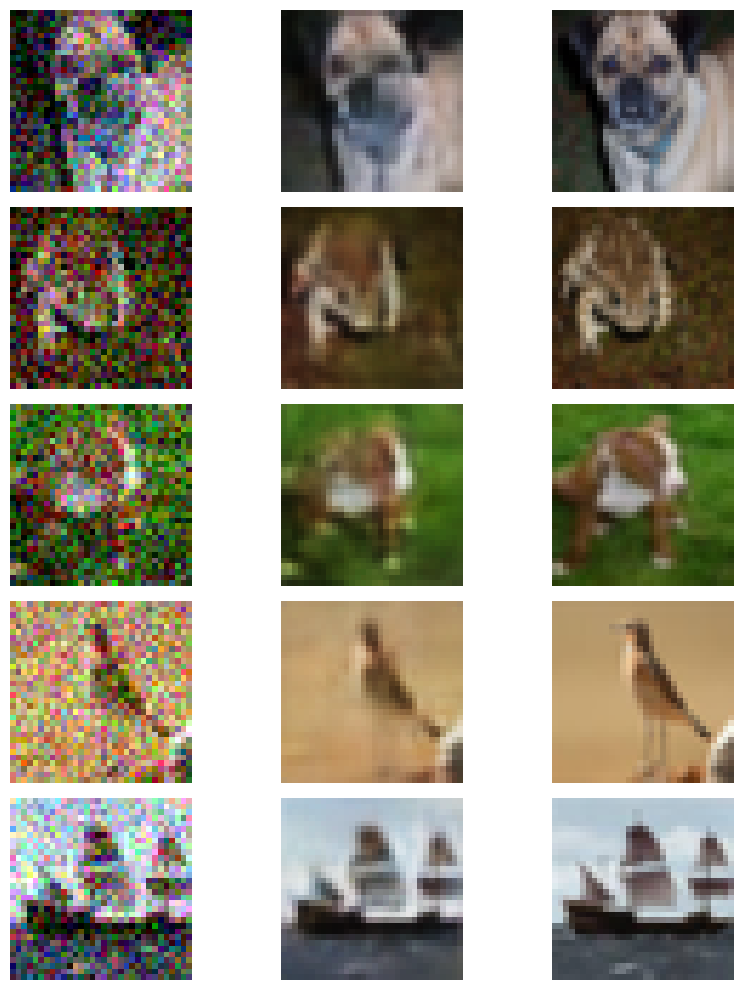

In [11]:
def denorm(x):
    return x * 0.5 + 0.5

model.eval()
noisy, clean = next(iter(loader))
noisy = noisy.to(device)

with torch.no_grad():
    output = model(noisy)

noisy = denorm(noisy.cpu())
output = denorm(output.cpu())
clean = denorm(clean)

plt.figure(figsize=(9,10))

for i in range(5):
    plt.subplot(5,3,3*i+1)
    plt.imshow(noisy[i].permute(1,2,0))
    plt.axis("off")

    plt.subplot(5,3,3*i+2)
    plt.imshow(output[i].permute(1,2,0))
    plt.axis("off")

    plt.subplot(5,3,3*i+3)
    plt.imshow(clean[i].permute(1,2,0))
    plt.axis("off")

plt.tight_layout()
plt.show()


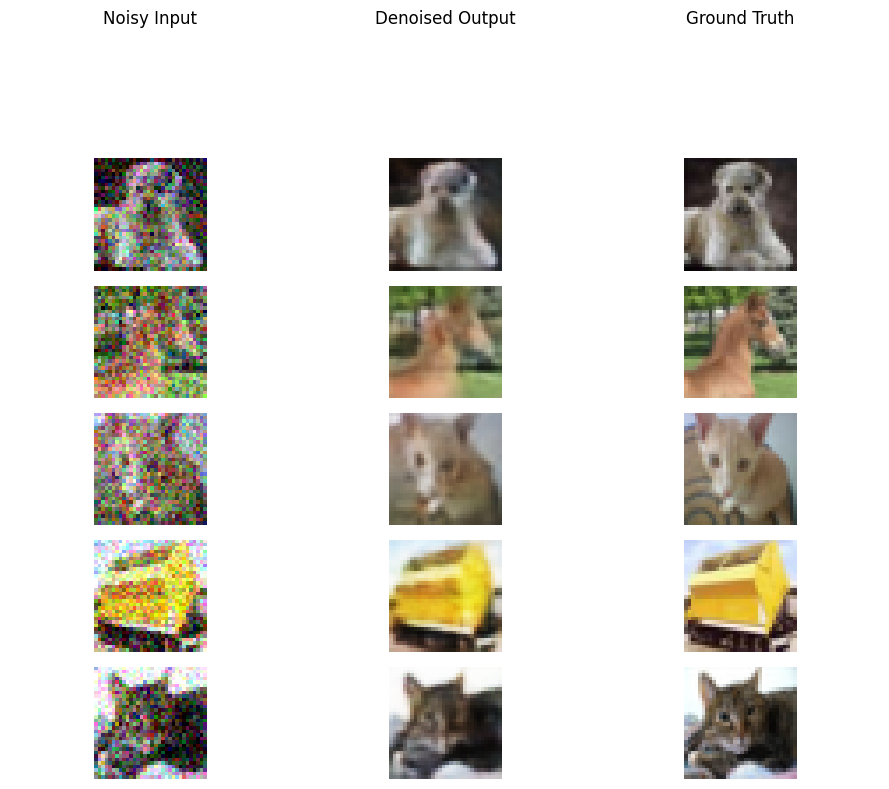

In [12]:
def denorm(x):
    return x * 0.5 + 0.5

model.eval()
noisy, clean = next(iter(loader))
noisy = noisy.to(device)

with torch.no_grad():
    output = model(noisy)

noisy = denorm(noisy.cpu())
output = denorm(output.cpu())
clean = denorm(clean)

num_samples = 5

plt.figure(figsize=(9, 8))

# Column titles (only once)
titles = ["Noisy Input", "Denoised Output", "Ground Truth"]

for col in range(3):
    plt.subplot(num_samples+1, 3, col+1)
    plt.title(titles[col], fontsize=12)
    plt.axis("off")

# Images
for i in range(num_samples):
    # Noisy
    plt.subplot(num_samples+1, 3, 3*(i+1)+1)
    plt.imshow(noisy[i].permute(1,2,0))
    plt.axis("off")

    # Output
    plt.subplot(num_samples+1, 3, 3*(i+1)+2)
    plt.imshow(output[i].permute(1,2,0))
    plt.axis("off")

    # Clean
    plt.subplot(num_samples+1, 3, 3*(i+1)+3)
    plt.imshow(clean[i].permute(1,2,0))
    plt.axis("off")

plt.tight_layout()
plt.show()


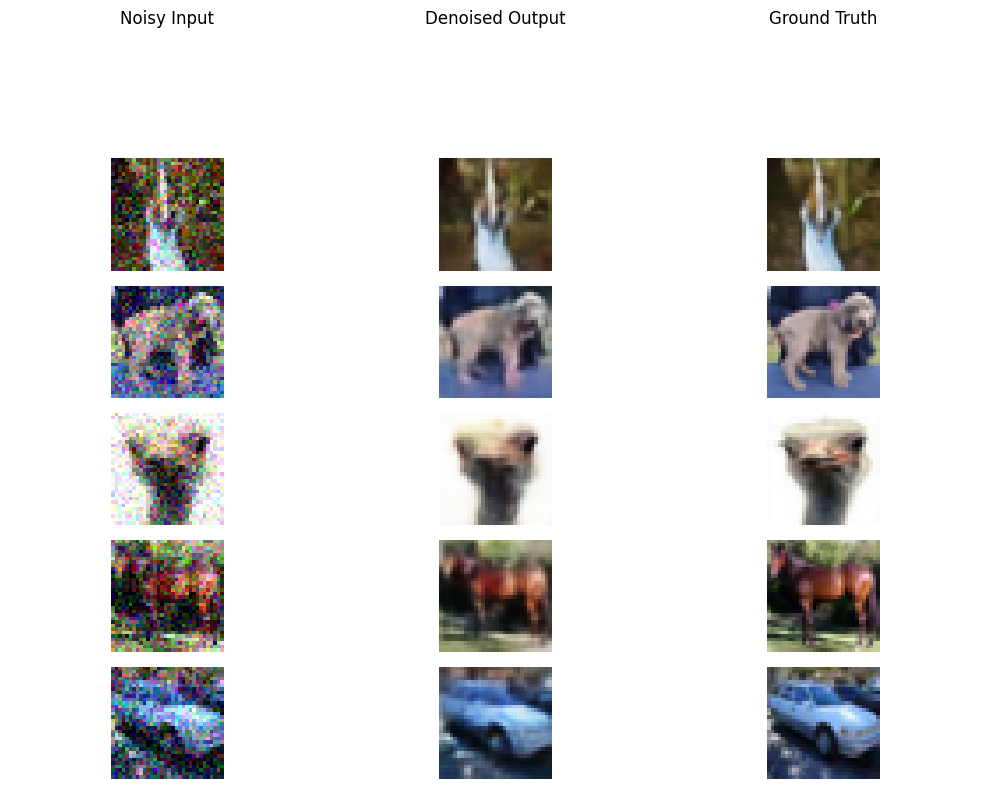

In [13]:
def denorm(x):
    return x * 0.5 + 0.5

model.eval()
noisy, clean = next(iter(loader))
labels = next(iter(loader))[1]  # get labels from original dataset

noisy = noisy.to(device)

with torch.no_grad():
    output = model(noisy)

noisy = denorm(noisy.cpu())
output = denorm(output.cpu())
clean = denorm(clean)

classes = dataset.classes
num_samples = 5

plt.figure(figsize=(10, 8))

# Column Titles
titles = ["Noisy Input", "Denoised Output", "Ground Truth"]

for col in range(3):
    plt.subplot(num_samples+1, 3, col+1)
    plt.title(titles[col], fontsize=12)
    plt.axis("off")

# Images with class names
for i in range(num_samples):

    class_name = classes[dataset.targets[i]]

    # Noisy
    plt.subplot(num_samples+1, 3, 3*(i+1)+1)
    plt.imshow(noisy[i].permute(1,2,0))
    plt.ylabel(class_name, fontsize=10)
    plt.axis("off")

    # Output
    plt.subplot(num_samples+1, 3, 3*(i+1)+2)
    plt.imshow(output[i].permute(1,2,0))
    plt.axis("off")

    # Clean
    plt.subplot(num_samples+1, 3, 3*(i+1)+3)
    plt.imshow(clean[i].permute(1,2,0))
    plt.axis("off")

plt.tight_layout()
plt.show()
